# Критерии успешности игр

# Содержание

- [Описание проекта](#1)
- [Общая информация о данных](#2)
- [Подготовка данных](#3)
- [Анализ данных](#4)
- [Составление портрета пользователя по регионам](#7)
- [Проверка гипотез](#5)
- [Заключение](#6)

# Описание проекта <a id='1'></a>

**Цель: Выявить определяющие успешность игры закономерности.**

На основе данных из открытых источников (до 2016 года: исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation) необходимо выявить определяющие успешность игры закономерности, что позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков»..

Путь к данным: 
- /datasets/games.csv

# Общая информация о данных <a id='2'></a>

Согласно документации к данным:

- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.


Данные за 2016 год могут быть неполными.

# Подготовка данных <a id='3'></a>

Оценим:
- общую информацию о данных;
- содержание строк с нулевыми значениями;
- содержание колонок в первых и последних строках таблицы;
- уникальные значения в колонках.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import math
df = pd.read_csv('/datasets/games.csv')

display(df.head(10))

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Приведем названия столбцов к нижнему регистру. Преобразуем данные в столбце year_of_release в тип int ('обойдя' наличие незаполненных ячеек; необходимости преобразовывать в к типу time нет ввиду наличия только года, а тип int сбережет ресурсы системы), а также данные в столбце user_score в тип float (это позволит проводить математические операции с данными столбца).

Строковое значение 'tbd' (вероятно означающее: To Be Determined (будет определено)) в столбце с оценкой пользователей не несет полезной для анализа информации. Заменим его на NaN.

В данных присутствует достаточно большое количество пропусков (что могло стать следствием неполноты открытых источников, из которых бралась информация). С целью недопущения внесения искажений в результаты анализа влияния исследуемых параметров, заменять отсутствующие значения средними или медианными значениями не будем.

In [3]:
df = df.rename(columns={'Name':'name', 'Platform':'platform', 'Year_of_Release':'year_of_release',
                        'Genre':'genre', 'NA_sales':'na_sales', 'EU_sales':'eu_sales',
                        'JP_sales':'jp_sales', 'Other_sales':'other_sales', 'Critic_Score':'critic_score',
                        'User_Score':'user_score', 'Rating':'rating'})

df['user_score'] = df['user_score'].replace('tbd', np.NaN)
df['user_score'] = df['user_score'].astype('float64')
df['year_of_release'] = pd.array(df['year_of_release'], dtype=pd.Int64Dtype())
df.info()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.4+ MB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


В колонках name, genre есть два пропуска. Посмотрим на них.

In [4]:
display(df[df['name'].isna()].head(10))

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


В строках отсутствуют записи о жанре и названии игры и др. Однако при формировании выборок два значения не окажут существенного влияния на результат, удалим их.

In [5]:
df = df.dropna(subset=['genre'])


Проверим наличие неявных дубликатов в данных.

In [6]:
print('platform:', df['platform'].unique())
print('genre:', df['genre'].unique())
print('user_score:', df['user_score'].unique())
print('rating:', df['rating'].unique())
print('critic_score:', df['critic_score'].unique())

platform: ['Wii' 'NES' 'GB' 'DS' 'X360' 'PS3' 'PS2' 'SNES' 'GBA' 'PS4' '3DS' 'N64'
 'PS' 'XB' 'PC' '2600' 'PSP' 'XOne' 'WiiU' 'GC' 'GEN' 'DC' 'PSV' 'SAT'
 'SCD' 'WS' 'NG' 'TG16' '3DO' 'GG' 'PCFX']
genre: ['Sports' 'Platform' 'Racing' 'Role-Playing' 'Puzzle' 'Misc' 'Shooter'
 'Simulation' 'Action' 'Fighting' 'Adventure' 'Strategy']
user_score: [8.  nan 8.3 8.5 6.6 8.4 8.6 7.7 6.3 7.4 8.2 9.  7.9 8.1 8.7 7.1 3.4 5.3
 4.8 3.2 8.9 6.4 7.8 7.5 2.6 7.2 9.2 7.  7.3 4.3 7.6 5.7 5.  9.1 6.5 8.8
 6.9 9.4 6.8 6.1 6.7 5.4 4.  4.9 4.5 9.3 6.2 4.2 6.  3.7 4.1 5.8 5.6 5.5
 4.4 4.6 5.9 3.9 3.1 2.9 5.2 3.3 4.7 5.1 3.5 2.5 1.9 3.  2.7 2.2 2.  9.5
 2.1 3.6 2.8 1.8 3.8 0.  1.6 9.6 2.4 1.7 1.1 0.3 1.5 0.7 1.2 2.3 0.5 1.3
 0.2 0.6 1.4 0.9 1.  9.7]
rating: ['E' nan 'M' 'T' 'E10+' 'K-A' 'AO' 'EC' 'RP']
critic_score: [76. nan 82. 80. 89. 58. 87. 91. 61. 97. 95. 77. 88. 83. 94. 93. 85. 86.
 98. 96. 90. 84. 73. 74. 78. 92. 71. 72. 68. 62. 49. 67. 81. 66. 56. 79.
 70. 59. 64. 75. 60. 63. 69. 50. 25. 42. 44. 55. 4

Неявные дубликаты не обнаружены.

Посчитаем суммарные продажи во всех регионах.

In [7]:
df['sales'] = df[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)


Заменим отсутствующие значения в столбце rating на not.

In [8]:
df['rating'] = df['rating'].fillna(value='not')

**Выводы**

По результатам подготовки данных:

- названия столбцов приведены к нижнему регистру
- данные в столбце year_of_release преобразованы в тип int ('обойдя' наличие незаполненных ячеек; необходимости преобразовывать в к типу time нет ввиду наличия только года)
- данные в столбце user_score преобразованы в тип float (это позволит проводить математические операции с данными столбца)
- неявные дубликаты в данных не обнаружены
- с целью недопущения внесения искажений в результаты анализа влияния исследуемых параметров, замена отсутствующих значений средними или медианными значениями не проводилась
- строковое значение 'tbd' (вероятно означающее: To Be Determined (будет определено)) заменено на NaN
- расчитаны суммарные продажи во всех регионах

# Анализ данных <a id='4'></a>

Посмотрим и проанализируем как выпускались игры по годам. 

<AxesSubplot:xlabel='year_of_release'>

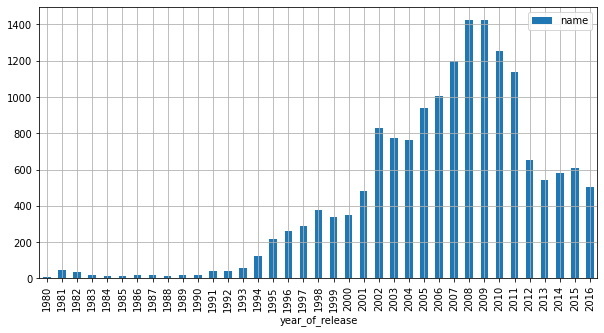

In [9]:
df_year = df.pivot_table(index=['year_of_release'], values='name', aggfunc=['count'])
df_year.plot(y = 'count', kind='bar', figsize = (10, 5), grid=True) 

На графике можно выделить несколько характерных периодов: период с 1980 по 1993 - характеризующийся сравнительно (по отношению к другим периодам) небольшим количеством (до 60) выпускаемых в год игр, период с 1994 по 2011 - характеризующийся бурным ростом количества выпускаемых в год игр (до 1427 в 2008 году) с небольшим снижением до 1136 в 2011 году, период с 2012 по 2016 годы - характеризующийся сначала стремительным уменьшением количества выпускаемых в год игр (почти в 2 раза - 2012 по сравнению с 2011), и примерно одинаковым количеством выпускаемых в год игр (около 600) с 2012 по 2016 годы. **Стабильно устойчивые показатели за 2012 - 2016 годы позволяют выбрать этот период для составления прогноза на 2017 год.**

Построим график продаж по платформам.

<AxesSubplot:xlabel='platform'>

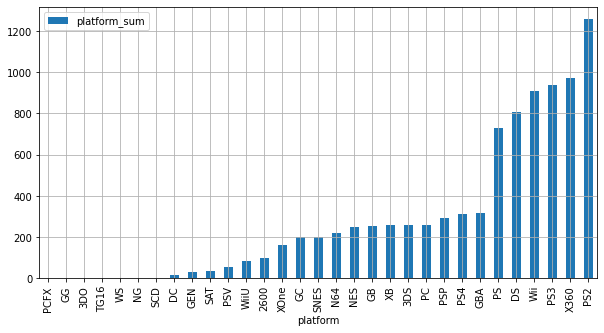

In [10]:
df_platform_sum = df.pivot_table(index=['platform'], values='sales', aggfunc=['sum'])
df_platform_sum.columns = ['platform_sum']
df_platform_sum.sort_values('platform_sum').plot(y = 'platform_sum', kind='bar', figsize = (10, 5), grid=True) 

Явные лидеры по объёму продаж, платформы: PS, DS, Wii, PS3, X360, PS2.

Построим диаграммы продаж игр для этих платформ по годам.

<AxesSubplot:xlabel='year_of_release'>

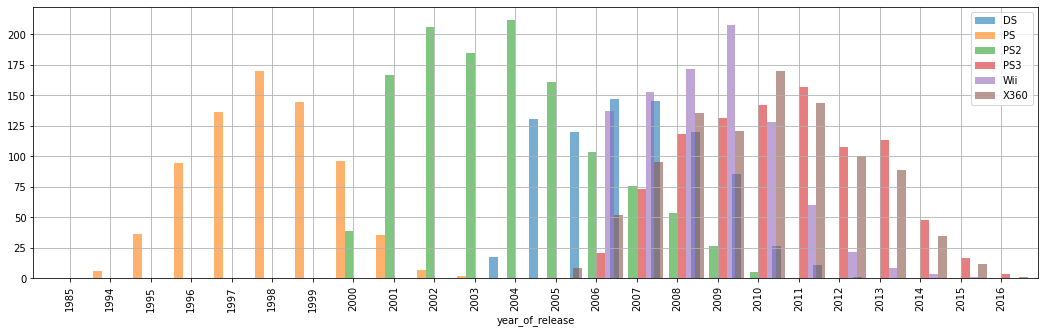

In [11]:
df_platform_max_sales = df.query('platform == "PS" or platform == "DS" or platform == "Wii" or platform == "PS3" or platform == "X360" or platform == "PS2"')
df_platform_max_sales_year = df_platform_max_sales.pivot_table(index=['year_of_release'], columns = ['platform'], values='sales', aggfunc=['sum'])
df_platform_max_sales_year.columns = ['DS', 'PS', 'PS2', 'PS3', 'Wii', 'X360']

df_platform_max_sales_year.plot(kind='bar', figsize = (18, 5), width = 1.3, alpha=0.6, grid=True)

Из диаграммы видно что, жизненный цикл платформы составляет порядка 10 лет. У каждой платформы можно выделить характерные периоды: роста  продаж, длящиеся 2-4 года, затем  пик продаж, длящийся 1-4 года, и спад продаж, длящийся 4-5 лет. 

Для выбора потенциально прибыльных платформ проанализируем период с 2011 по 2016 годы. Учитывая, что данные за 2016 год не полные, данные за 2016 год в анализе учитывать не будем. Определим какие платформы лидируют по продажам, растут, падают. Выберем несколько растущих платформ.

<AxesSubplot:xlabel='year_of_release'>

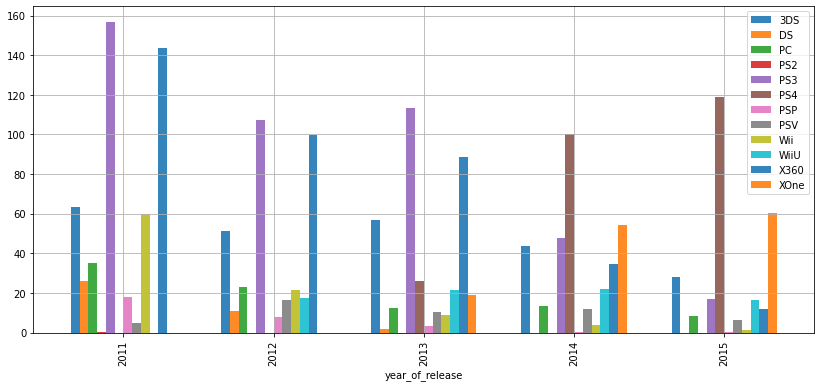

In [12]:
df_last_years = df.query('2010 < year_of_release < 2016')
df_last_years_sales = df_last_years.pivot_table(index=['year_of_release'], columns = ['platform'], values='sales', aggfunc=['sum'])
df_last_years_sales.columns = ['3DS', 'DS', 'PC', 'PS2', 'PS3', 'PS4', 'PSP', 'PSV', 'Wii', 'WiiU', 'X360', 'XOne']

df_last_years_sales.plot(kind='bar', figsize = (14, 6), width = 0.7, alpha=0.9, grid=True)

Из графика видно, что платформы 3DS, DS, PC, PS3, PSP, Wii, X360 падают по продажам, их не стои выбирать как перспективные. Растущие платформы XOne, PS4 - перспективные. Можно предположить что продажи в 2016 и 2017 году по платформам XOne, PS4 будут расти, или остануться примерно такими как в 2015 году.

Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам. 

<AxesSubplot:>

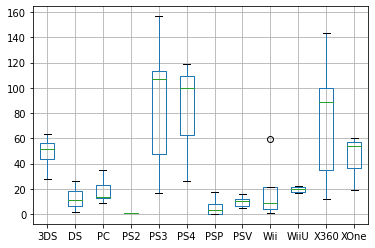

In [13]:
df_last_years_sales.boxplot()

Анализируя «ящик с усами» видно, что платформы  DS, PC, PSP, Wii имеют небольшой разброс данных по сравнению с PS3, PS4, X360; XOne 3DS имеют примерно одинаковый, сравнительно небольшой разброс данных. Стоит отметить большие (свыше 140) верхние значения   1,5IQR для PS3, X360; их медианные и средние значения, также значительно выше по сравнинию с другими платформами. На основании вышеизложенного можно предположить что потенциал прибыльности платформы PS4 выше по сравнению с XOne. 

Численные значения характеристики распределения по каждой платформе приведены ниже.

In [14]:
df_last_years_sales.describe()  

,3DS,DS,PC,PS2,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
count,5.000000,3.000000,5.000000,1.00,5.000000,3.000000,5.000000,5.000000,5.000000,4.000000,5.000000,3.00000
mean,48.534000,12.910000,18.486000,0.45,88.394000,81.630000,5.802000,9.912000,18.968000,19.397500,75.772000,44.39000
std,13.612262,12.429397,10.721725,NaN,55.740771,49.103561,7.387558,4.613428,24.081485,2.867489,52.743149,22.23117
min,27.780000,1.540000,8.520000,0.45,16.820000,25.990000,0.120000,4.630000,1.140000,16.350000,11.960000,18.96000
25%,43.760000,6.275000,12.380000,0.45,47.760000,62.995000,0.240000,6.250000,3.750000,17.257500,34.740000,36.51500
50%,51.360000,11.010000,13.280000,0.45,107.360000,100.000000,3.140000,10.590000,8.590000,19.605000,88.580000,54.07000
75%,56.570000,18.595000,23.220000,0.45,113.250000,109.450000,7.690000,11.900000,21.710000,21.745000,99.740000,57.10500
max,63.200000,26.180000,35.030000,0.45,156.780000,118.900000,17.820000,16.190000,59.650000,22.030000,143.840000,60.14000


Построим диаграммы рассеяния и посчитаем корреляцию между отзывами и продажами.

In [15]:
df_ps2 = df.query('platform == "PS2"')
df_ps3 = df.query('platform == "PS3"')
df_ps4 = df.query('platform == "PS4"')
df_XOne = df.query('platform == "XOne"')


<AxesSubplot:xlabel='critic_score', ylabel='sales'>

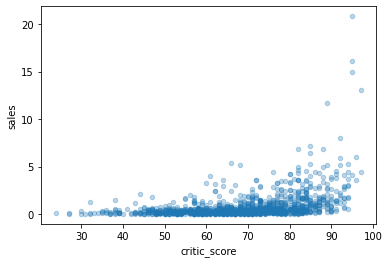

In [16]:
df_ps2.plot(x='critic_score', y='sales', kind='scatter', alpha=0.3)

<AxesSubplot:xlabel='user_score', ylabel='sales'>

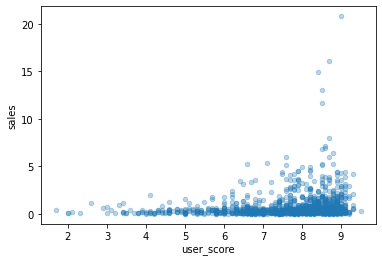

In [17]:
df_ps2.plot(x='user_score', y='sales', kind='scatter', alpha=0.3)

<AxesSubplot:xlabel='critic_score', ylabel='sales'>

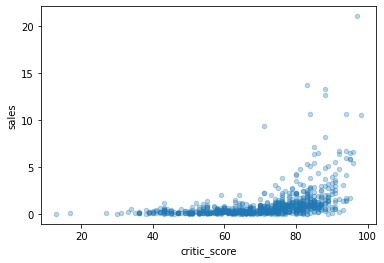

In [18]:
df_ps3.plot(x='critic_score', y='sales', kind='scatter', alpha=0.3)

<AxesSubplot:xlabel='user_score', ylabel='sales'>

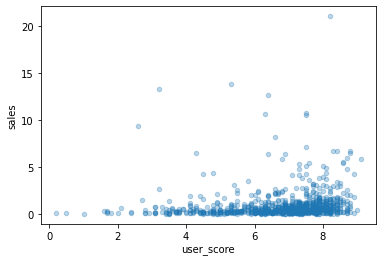

In [19]:
df_ps3.plot(x='user_score', y='sales', kind='scatter', alpha=0.3)

<AxesSubplot:xlabel='critic_score', ylabel='sales'>

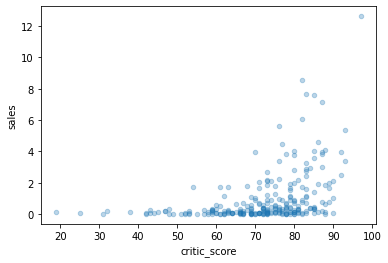

In [20]:
df_ps4.plot(x='critic_score', y='sales', kind='scatter', alpha=0.3)

<AxesSubplot:xlabel='user_score', ylabel='sales'>

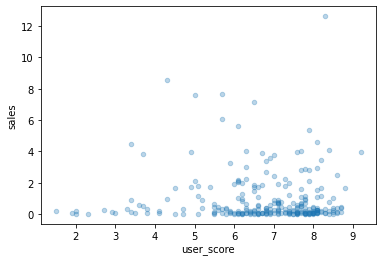

In [21]:
df_ps4.plot(x='user_score', y='sales', kind='scatter', alpha=0.3)

<AxesSubplot:xlabel='critic_score', ylabel='sales'>

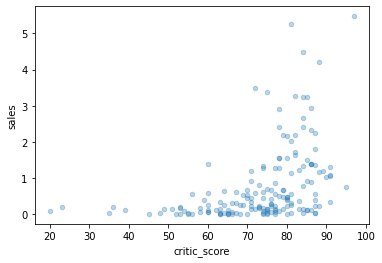

In [22]:
df_XOne.plot(x='critic_score', y='sales', kind='scatter', alpha=0.3)

<AxesSubplot:xlabel='user_score', ylabel='sales'>

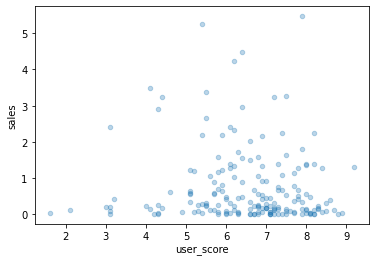

In [23]:
df_XOne.plot(x='user_score', y='sales', kind='scatter', alpha=0.3)

In [24]:
print('ps2_corr:', df_ps2['critic_score'].corr(df_ps2['sales'])) 
print('ps2_corr_user:', df_ps2['user_score'].corr(df_ps2['sales'])) 
print('ps3_corr:', df_ps3['critic_score'].corr(df_ps3['sales'])) 
print('ps3_corr_user:', df_ps3['user_score'].corr(df_ps3['sales'])) 
print('ps4_corr:', df_ps4['critic_score'].corr(df_ps4['sales'])) 
print('ps4_corr_user:', df_ps4['user_score'].corr(df_ps4['sales'])) 
print('XOne_corr:', df_XOne['critic_score'].corr(df_XOne['sales'])) 


print('corr_all:', df['critic_score'].corr(df['sales'])) 


ps2_corr: 0.39543454945454865
ps2_corr_user: 0.17286551112058185
ps3_corr: 0.43243156856420595
ps3_corr_user: 0.12669133936341698
ps4_corr: 0.4065679020617816
ps4_corr_user: -0.03195711020455643
XOne_corr: 0.4169983280084017
corr_all: 0.2455066871773633


Построенные для топовых платформ диаграммы рассеяния и расчитанные коэффициенты коряляции показывают наличие взаимосвязи между отзывами и продажами, слабой - между отзывами критиков и продажами и  очень слабой - с отзывами пользователей и продажами. При этом для всей выборки связь еще слабее.

Построим диаграмму распеделения медианных значений продаж по жанрам. 

<AxesSubplot:xlabel='genre'>

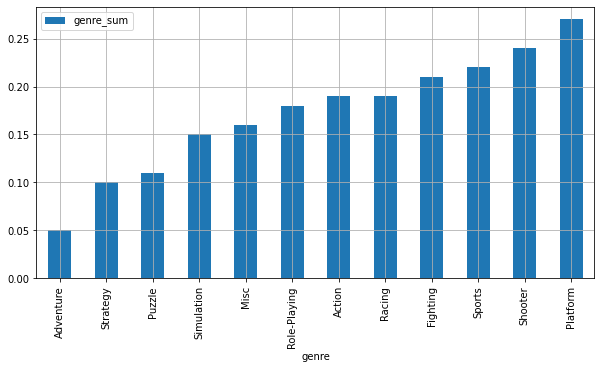

In [25]:
df_genre_sum = df.pivot_table(index=['genre'], values='sales', aggfunc=['median'])
df_genre_sum.columns = ['genre_sum']
df_genre_sum.sort_values('genre_sum').plot(y = 'genre_sum', kind='bar', figsize = (10, 5), grid=True) 


<AxesSubplot:xlabel='genre'>

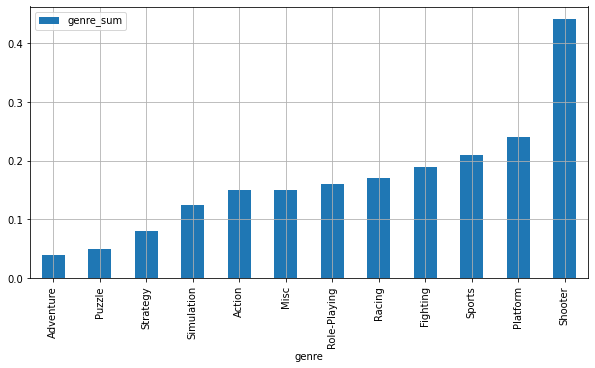

In [26]:
df_genre_sum_last_years = df_last_years.pivot_table(index=['genre'], values='sales', aggfunc=['median'])
df_genre_sum_last_years.columns = ['genre_sum']
df_genre_sum_last_years.sort_values('genre_sum').plot(y = 'genre_sum', kind='bar', figsize = (10, 5), grid=True) 

Как видно из диаграмм что за весь наблюдаемый период наиболее прибыльными являются жанры Shooter и Platform наименее прибыльные Adventure. Если анализировать данные за последние 5 лет видно что пользователи также отдают предпочтение жанрам Shooter и Platform, причем явно лидирует Shooter. На последнем месте Adventure.

# Составление портрета пользователя по регионам <a id='7'></a>

Определим для каждого региона самые популярные платформы.


array([<AxesSubplot:ylabel='na_sum'>, <AxesSubplot:ylabel='eu_sum'>,
       <AxesSubplot:ylabel='jp_sum'>], dtype=object)

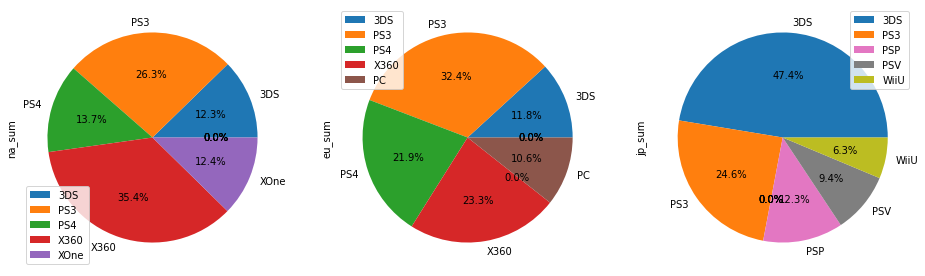

In [27]:
df_na_platform = df_last_years.pivot_table(index=['platform'], values='na_sales', aggfunc=['sum'])
df_eu_platform = df_last_years.pivot_table(index=['platform'], values='eu_sales', aggfunc=['sum'])
df_jp_platform = df_last_years.pivot_table(index=['platform'], values='jp_sales', aggfunc=['sum'])

df_na_platform.columns = ['na_sum']
df_eu_platform.columns = ['eu_sum']
df_jp_platform.columns = ['jp_sum']

df_na_platform_top = df_na_platform.query('na_sum > 50')
df_eu_platform_top = df_eu_platform.query('eu_sum > 50')
df_jp_platform_top = df_jp_platform.query('jp_sum > 11')

df_platform_full = pd.merge(df_na_platform_top, df_eu_platform_top, on=['platform'], how='outer')
df_platform_full = pd.merge(df_platform_full, df_jp_platform_top, on=['platform'], how='outer')

df_platform_full.plot(subplots=True, kind='pie', autopct='%1.1f%%', figsize = (16, 8), grid=True) 

Из диаграмм видно, что в Америке наиболее популярна платформа Х360 (35%), затем идет PS3 (26%) затем с примерно одинаковыми долями PS4, 3DS, XOne при этом примечательно что последняя входит в топ 5 только в Америке. В Европе наибольшую популярность имеют PS3(32%), Х360(23%), PS4(21%) с общим объемом продаж почти 80%, 3DS и PC занимают всего 22% рынка. В Японии явно отличающаяся картина: платформы 3DS(23%), PS3(23%) более 70% рынка и отсутствующие в топ 5 платфрмы PSP PSV WiiU почти 30%. При этом стоит отметить всеобщую популярность(25-32%) платформы PS3.

Определим для каждого региона самые популярные жанры.


array([<AxesSubplot:ylabel='na_sum'>, <AxesSubplot:ylabel='eu_sum'>,
       <AxesSubplot:ylabel='jp_sum'>], dtype=object)

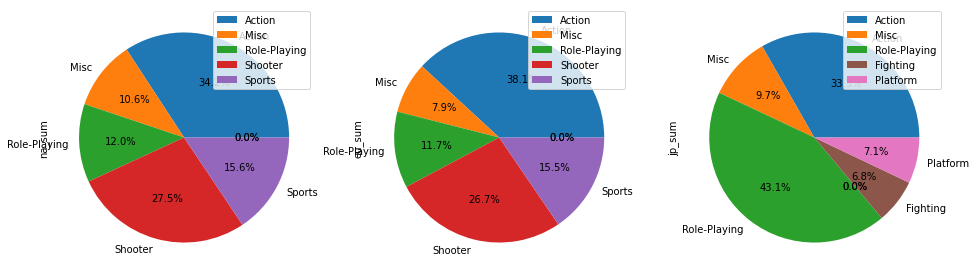

In [28]:
df_na = df_last_years.pivot_table(index=['genre'], values='na_sales', aggfunc=['sum'])
df_eu = df_last_years.pivot_table(index=['genre'], values='eu_sales', aggfunc=['sum'])
df_jp = df_last_years.pivot_table(index=['genre'], values='jp_sales', aggfunc=['sum'])

df_na.columns = ['na_sum']
df_eu.columns = ['eu_sum']
df_jp.columns = ['jp_sum']

df_na_top = df_na.query('na_sum > 68')
df_eu_top = df_eu.query('eu_sum > 39')
df_jp_top = df_jp.query('jp_sum > 11.5')

df_genre_full = pd.merge(df_na_top, df_eu_top, on=['genre'], how='outer')
df_genre_full = pd.merge(df_genre_full, df_jp_top, on=['genre'], how='outer')

df_genre_full.plot(subplots=True, kind='pie', autopct='%1.1f%%', figsize = (16, 8), grid=True) 

Из диаграмм видно практически полное совпадение популярных жанров в Америке и Европе: Action, Shooter, Sports занимают почти 80% продаж, Role-Playing, Misc - 22%. Стоит отметить что в Японии такие жанры как Action и Misc имеют примерно такую же популярность как в Европе и Америке. При этом большой сегмент (43%) занимают Role-Playing.

In [29]:
df_na_esrb = df_last_years.pivot_table(index=['rating'], values='na_sales', aggfunc=['sum'])
df_eu_esrb = df_last_years.pivot_table(index=['rating'], values='eu_sales', aggfunc=['sum'])
df_jp_esrb = df_last_years.pivot_table(index=['rating'], values='jp_sales', aggfunc=['sum'])

df_na_esrb.columns = ['na_sales']
df_eu_esrb.columns = ['eu_sales']
df_jp_esrb.columns = ['jp_sales']

df_esrb_full = pd.merge(df_na_esrb, df_eu_esrb, on=['rating'], how='outer')
df_esrb_full = pd.merge(df_esrb_full, df_jp_esrb, on=['rating'], how='outer')

# display(df_esrb_full)

# df_last_years

array([<AxesSubplot:ylabel='na_sales'>, <AxesSubplot:ylabel='eu_sales'>,
       <AxesSubplot:ylabel='jp_sales'>], dtype=object)

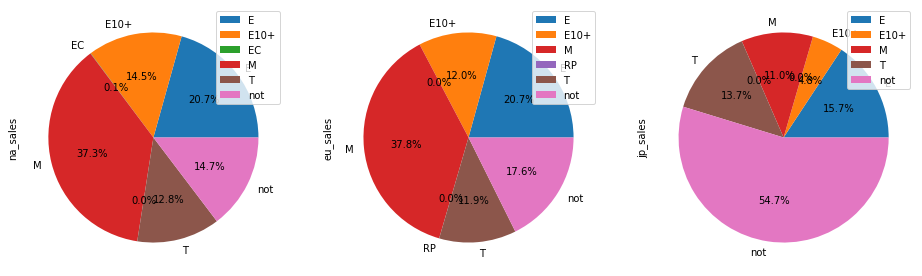

In [30]:
df_esrb_full.plot(subplots=True, kind='pie', autopct='%1.1f%%', figsize = (16, 8), grid=True) 

Из диаграмм видно, что в Европе и Америке продажи игр по сегментам рейтинга ESRB распределены одинаково. Большую часть продаж занимают игры с рейтингом М («M» («Mature») — «Для взрослых», 37%), игры без рейтинга занимают всего 15-18%. Очевидно, что в  Японии наличие рейтинга ESRB не играет ключевого значения, - более 50% игр продаётся без рейтинга.

# Проверка гипотез <a id='5'></a>

Сформируем и оценим данные для анализа.

In [31]:
df_xb_pc = df.query('platform == "XB" or platform == "PC"')
df_xb = df.query('platform == "XB" and user_score >= 0')
df_pc = df.query('platform == "PC" and user_score >= 0')

df_xb_pc_char = df_xb_pc.pivot_table(index=['platform'], values='user_score', aggfunc=['mean', 'var', 'std'])
df_xb_pc_char



,mean,var,std
,user_score,user_score,user_score
platform,,,
PC,7.062468,2.340787,1.529963
XB,7.500512,2.279675,1.509859


Выдвинем нулевую гипотезу: средние пользовательские рейтинги платформ Xbox One и PC равны, альтернативная гипотеза - средние пользовательские рейтинги платформ Xbox One и PC  различаются.
С учётом того, что работаем с сформированными из гененральных совокупностей выборками, для проверки используем специальный метод  проверки гипотез о равенстве среднего двух генеральных совокупностей по взятым из них выборкам (t-тест): scipy.stats.ttest_ind (благодаря ЦПТ этот метод можно применить, - если размер выборки составляет хотя бы несколько десятков значений, выборочные средние, которые можно получить из одной и той же генеральной совокупности, будут распределены нормально вокруг истинного среднего этой совокупности; это утверждение верно, даже если сама генеральная совокупность не распределена нормально). Критический уровень статистической значимости примем равным 0,05, если p-value окажется меньше него - отвергнем гипотезу

In [32]:
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    df_xb['user_score'], 
    df_pc['user_score'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. Средние пользовательские рейтинги платформ Xbox One и PC различаются.")
else:
    print("Не получилось отвергнуть нулевую гипотезую. Средние пользовательские рейтинги платформ Xbox One и PC равны.") 

p-значение: 1.7410111940926608e-07
Отвергаем нулевую гипотезу. Средние пользовательские рейтинги платформ Xbox One и PC различаются.


Выдвинем нулевую гипотезу: cредние пользовательские рейтинги жанров Action и Sports равны, альтернативная гипотеза - cредние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») не равны.  Учитывая некоторое отличие дисперсий, укажем equal_var = False. 

In [33]:
df_action_sports = df.query('genre == "Action" or genre == "Sports"')
df_action = df.query('genre == "Action" and user_score >= 0')
df_sports = df.query('genre == "Sports" and user_score >= 0')

df_action_sports_char = df_action_sports.pivot_table(index=['genre'], values='user_score', aggfunc=['mean', 'var', 'std'])
df_action_sports_char

,mean,var,std
,user_score,user_score,user_score
genre,,,
Action,7.054044,2.031747,1.425394
Sports,6.961197,2.596515,1.611370


In [34]:
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    df_xb['user_score'], 
    df_pc['user_score'], equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. Средние пользовательские рейтинги жанров Action и Sports различаются.")
else:
    print("Не получилось отвергнуть нулевую гипотезую. Средние пользовательские рейтинги жанров Action и Sports равны.") 

p-значение: 1.6723325756706098e-07
Отвергаем нулевую гипотезу. Средние пользовательские рейтинги жанров Action и Sports различаются.


# Заключение <a id='6'></a>

При подготовке данных:
- названия столбцов приведены к нижнему регистру
- данные в столбце year_of_release преобразованы в тип int ('обойдя' наличие незаполненных ячеек; необходимости преобразовывать в к типу time нет ввиду наличия только года)
- данные в столбце user_score преобразованы в тип float (это позволит проводить математические операции с данными столбца)
- неявные дубликаты в данных не обнаружены
- с целью недопущения внесения искажений в результаты анализа влияния исследуемых параметров, замена отсутствующих значений средними или медианными значениями не проводилась
- строковое значение 'tbd' (вероятно означающее: To Be Determined (будет определено)) заменено на NaN
- расчитаны суммарные продажи во всех регионах

В результате анализа:
- выделены несколько характерных периодов: период с 1980 по 1993 - характеризующийся сравнительно (по отношению к другим периодам) небольшим количеством (до 60) выпускаемых в год игр, период с 1994 по 2011 - характеризующийся бурным ростом количества выпускаемых в год игр (до 1427 в 2008 году) с небольшим снижением до 1136 в 2011 году, период с 2012 по 2016 годы - характеризующийся сначала стремительным уменьшением количества выпускаемых в год игр (почти в 2 раза - 2012 по сравнению с 2011), и примерно одинаковым количеством выпускаемых в год игр (около 600) с 2012 по 2016 годы.
- **стабильно устойчивые показатели за 2012 - 2016 годы позволили выбрать этот период для составления прогноза на 2017 год.**
- определены явные лидеры по объёму продаж, это платформы: PS, DS, Wii, PS3, X360, PS2.
- определено, что жизненный цикл платформы составляет порядка 10 лет. У каждой платформы выделили характерные периоды: роста  продаж, длящиеся 2-4 года, затем  пик продаж, длящийся 1-4 года, и спад продаж, длящийся 4-5 лет. 
- определено, что платформы 3DS, DS, PC, PS3, PSP, Wii, X360 падают по продажам, их не стоит выбирать как перспективные.
- **определены перспективные "растущие" платформы XOne, PS4. Предположительно продажи в 2016 и 2017 году по платформам XOne, PS4 будут расти, или остануться примерно такими как в 2015 году.**
- показано, что платформы  DS, PC, PSP, Wii имеют небольшой разброс данных по сравнению с PS3, PS4, X360. Платформы XOne 3DS имеют примерно одинаковый, сравнительно небольшой разброс данных. Отмечены,  большие (свыше 140) верхние значения   1,5IQR для PS3, X360; а также то что их медианные и средние значения, также значительно выше по сравнинию с другими платформами. На основании вышеизложенного можно предположить что потенциал прибыльности платформы PS4 выше по сравнению с XOne.
- **построенные для топовых платформ диаграммы рассеяния и расчитанные коэффициенты коряляции показали наличие взаимосвязи между отзывами и продажами: слабой - между отзывами критиков и продажами (к.к - 0,4) и  очень слабой - с отзывами пользователей и продажами. При этом для всей выборки связь еще слабее (к.к 0,25)**.
- **определено, xnj за весь наблюдаемый период наиболее прибыльными являются жанры Shooter и Platform наименее прибыльные Adventure. Если анализировать данные за последние 5 лет видно что пользователи также отдают предпочтение жанрам Shooter и Platform, причем явно лидирует Shooter. На последнем месте Adventure.**

По построенным круговым диаграммам:
- **определено, что в Америке наиболее популярна платформа Х360 (35%), затем идет PS3 (26%) затем с примерно одинаковыми долями PS4, 3DS, XOne при этом примечательно что последняя входит в топ 5 только в Америке. В Европе наибольшую популярность имеют PS3(32%), Х360(23%), PS4(21%) с общим объемом продаж почти 80%, 3DS и PC занимают всего 22% рынка. В Японии явно отличающаяся картина: платформы 3DS(47%), PS3(25%)  и отсутствующие в топ 5 в Европе и Америке - платфрмы PSP, PSV, WiiU - почти 30%. При этом стоит отметить всеобщую популярность(25-32%) платформы PS3.**
- **определено, что Америке и Европе жанры Action, Shooter, Sports занимают почти 80% продаж, Role-Playing, Misc - 22%. В Японии такие жанры как Action и Misc имеют примерно такую же популярность как в Европе и Америке. При этом большой сегмент (43%) занимают Role-Playing.**
- **определено, что в Европе и Америке продажи игр по сегментам рейтинга ESRB распределены одинаково. Большую часть продаж занимают игры с рейтингом М («M» («Mature») — «Для взрослых», 37%), игры без рейтинга занимают всего 15-18%. Очевидно, что в  Японии наличие рейтинга ESRB не играет ключевого значения, - более 50% игр продаётся без рейтинга.**

По результатам проверки гипотез.
- выдвинутая нулевая гипотеза: "средние пользовательские рейтинги платформ Xbox One и PC равны" отвергнута. Определено, что средние пользовательские рейтинги платформ Xbox One и PC различаются.
- выдвинутая нулевая гипотеза: "cредние пользовательские рейтинги жанров Action и Sports равны" отвергнута. Определено, что средние пользовательские рейтинги жанров Action и Sports различаются.